# GCN Clustering Analysis

GCN Clustering clusters the graph into M subgraphs and uses those as mini-batches to speed up training. One problem is that might ignore between-cluster links which might affect the message passing of a GCN. The current method of random sampling q clusters to create a batch might not be too effective in catching between-cluster links if there is a low probability of the batch containing them. Below I do an analysis pretending each node in the graph is a cluster

In [1]:
import numpy as np
import torch
from torch_geometric.utils import from_scipy_sparse_matrix, to_networkx
from scipy.sparse import coo_matrix
import networkx as nx

conn = np.load(f'../data/xbar/1/xbar_connectivity.npz')
A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
A = A.__mul__(A.T)

edges = from_scipy_sparse_matrix(A)
edge_list = [(u.item(),v.item(), weight) for u, v, weight in zip(edges[0][0], edges[0][1], edges[1])]
G = nx.Graph()
G.add_weighted_edges_from(edge_list)
G.remove_edges_from(nx.selfloop_edges(G))

KeyboardInterrupt: 

In [2]:
from batching import Batcher
from load import load_data

data = load_data()

  0%|          | 0/13 [02:06<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../data/xbar/29/xbar_connectivity.npz'

In [3]:
from tqdm import tqdm

for i in tqdm(range(5)):
    print(i)

100%|██████████| 5/5 [00:00<?, ?it/s]

0
1
2
3
4


In [102]:
batcher = Batcher(3, method="fm", as_graph=True)
graphs = batcher(data)

In [203]:
partitions = nx.community.k_clique_communities(G, 30)
cliques = list(partitions)

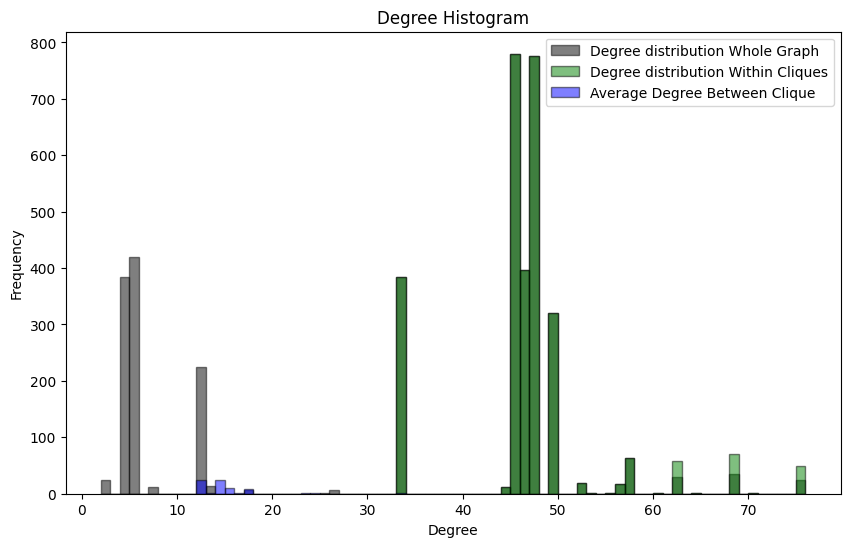

In [157]:
import networkx as nx
import matplotlib.pyplot as plt
import collections

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence

fig, ax = plt.subplots(figsize=(10, 6))  # Increase the figure size
plt.hist(degree_sequence, bins=range(min(degree_sequence), max(degree_sequence) + 1), color="black", edgecolor='black',alpha=0.5, label="Degree distribution Whole Graph")

import itertools

# Flatten the list of cliques into a single list of nodes
all_nodes = list(itertools.chain.from_iterable(cliques))

# Get the degrees of all nodes
all_degrees = [G.degree(n) for n in all_nodes]

# Create a histogram of the degrees
plt.hist(all_degrees, bins=range(min(degree_sequence), max(degree_sequence) + 1), color="green", edgecolor='black', alpha=0.5, label="Degree distribution Within Cliques")


# Initialize a list to store the average degrees of the cliques
clique_avg_degrees = []

# For each clique
for clique in cliques:
    # Convert the clique to a set for faster membership tests
    clique_set = set(clique)

    # Initialize a counter for the number of edges to different cliques
    count = 0

    # For each node in the clique
    for node in clique:
        # For each neighbor of the node
        for neighbor in G.neighbors(node):
            # If the neighbor is not in the same clique
            if neighbor not in clique_set:
                # Increment the counter
                count += 1

    # Calculate the average degree of the clique and add it to the list
    clique_avg_degrees.append(count / len(clique))

# Create a histogram of the average clique degrees
plt.hist(clique_avg_degrees, bins=range(min(degree_sequence), max(degree_sequence) + 1), color="blue", edgecolor='black', alpha=0.5, label="Average Degree Between Clique")

plt.legend()


plt.title("Degree Histogram")
plt.ylabel("Frequency")
plt.xlabel("Degree")
# ax.set_xticks([d + 0.5 for d in range(min(degree_sequence), max(degree_sequence) + 1)])  # Adjust the x-ticks
# ax.set_xticklabels(range(min(degree_sequence), max(degree_sequence) + 1), rotation=90, fontsize='small')  # Rotate the labels and use a smaller font size

plt.show()

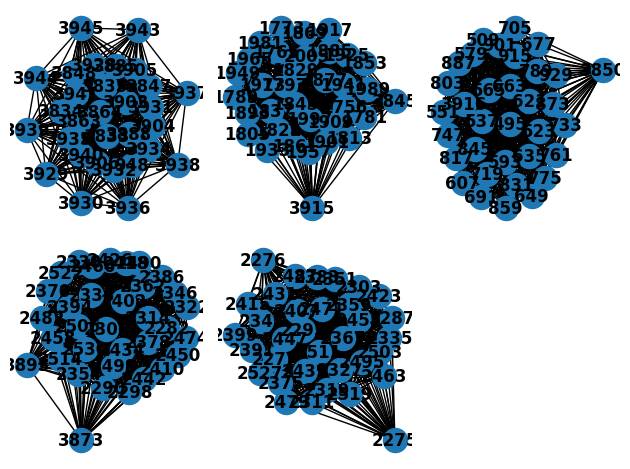

In [160]:
import random
# turn each clique into a graph
clique_graphs = [G.subgraph(clique) for clique in cliques]
# Select a random sample of cliques
sample_cliques = random.sample(clique_graphs, k=5)

# Create a new figure
plt.figure()

# Draw each clique graph
for i, clique_graph in enumerate(sample_cliques):
    plt.subplot(2, 3, i+1)
    nx.draw(clique_graph, with_labels=True, font_weight='bold')

# Adjust the layout of subplots
plt.tight_layout()

# Show the plot
plt.show()

In [161]:
def calculate_overlap(cliques):
    total_overlap = 0
    total_pairs = 0
    
    for i in range(len(cliques)):
        for j in range(i+1, len(cliques)):
            clique1 = set(cliques[i])
            clique2 = set(cliques[j])
            overlap = len(clique1.intersection(clique2))
            total_overlap += overlap
            total_pairs += 1
    
    percent_overlap = (total_overlap / total_pairs) * 100
    return percent_overlap

overlap_percent = calculate_overlap(cliques)
print(f"The percent of overlap between cliques is: {overlap_percent}%")


The percent of overlap between cliques is: 2.405773857257418%


Number of edges between clique 1 and clique 2: 1
Number of edges between clique 1 and clique 3: 1
Number of edges between clique 1 and clique 4: 1
Number of edges between clique 1 and clique 5: 1
Number of edges between clique 1 and clique 6: 1
Number of edges between clique 1 and clique 7: 1
Number of edges between clique 1 and clique 8: 1
Number of edges between clique 1 and clique 9: 1
Number of edges between clique 1 and clique 10: 1
Number of edges between clique 1 and clique 11: 1
Number of edges between clique 1 and clique 12: 1
Number of edges between clique 1 and clique 13: 0
Number of edges between clique 1 and clique 14: 0
Number of edges between clique 1 and clique 15: 0
Number of edges between clique 1 and clique 16: 0
Number of edges between clique 1 and clique 17: 0
Number of edges between clique 1 and clique 18: 0
Number of edges between clique 1 and clique 19: 0
Number of edges between clique 1 and clique 20: 0
Number of edges between clique 1 and clique 21: 0
Number o

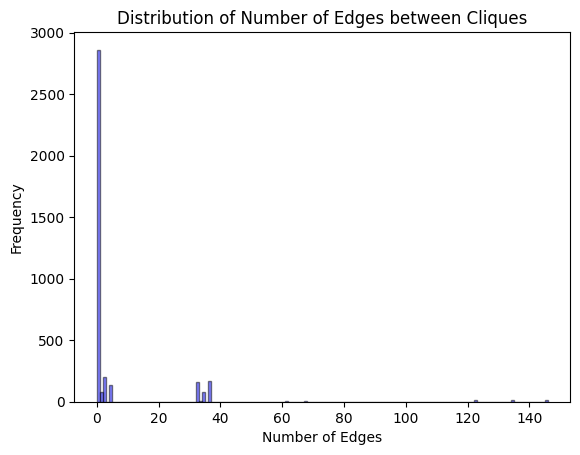

In [169]:
def count_edges_between_cliques(G, clique1, clique2):
    count = 0
    for node1 in clique1:
        for node2 in clique2:
            if G.has_edge(node1, node2):
                count += 1
    return count

# Iterate over all pairs of cliques
for i in range(len(cliques)):
    for j in range(i+1, len(cliques)):
        clique1 = cliques[i]
        clique2 = cliques[j]
        edge_count = count_edges_between_cliques(G, clique1, clique2)
        print(f"Number of edges between clique {i+1} and clique {j+1}: {edge_count}")

import matplotlib.pyplot as plt

# Create an empty list to store the edge counts
edge_counts = []

# Iterate over all pairs of cliques
for i in range(len(cliques)):
    for j in range(i+1, len(cliques)):
        clique1 = cliques[i]
        clique2 = cliques[j]
        edge_count = count_edges_between_cliques(G, clique1, clique2)
        edge_counts.append(edge_count)

# Plot the distribution of edge counts
plt.hist(edge_counts, bins=range(min(edge_counts), max(edge_counts) + 1), color="blue", edgecolor='black', alpha=0.5)
plt.title("Distribution of Number of Edges between Cliques")
plt.xlabel("Number of Edges")
plt.ylabel("Frequency")
plt.show()


In [258]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Batch

data.x = data.x.float()  # Convert node features to float
data.y = data.y.float()
mean = data.x.mean(dim=0, keepdim=True)
std = data.x.std(dim=0, keepdim=True)
data.x = (data.x - mean) / std

class GCN(torch.nn.Module):
    def __init__(self, num_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, 1)  # Change the output layer to have one output neuron

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = torch.dropout(x, p=0.5, train=self.training)
        x = self.conv2(x, edge_index)

        return x

def train_gcn(model, data, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()  # Change the loss function to MSE


    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        print(f"Epoch {epoch} Model Loss: {loss.item()}")
        loss.backward()
        optimizer.step()


from torch_geometric.utils import from_networkx

def train_gcn_with_cliques(model, G, data, k, batch_size, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.MSELoss()

    G = to_networkx(data, to_undirected=True)

    # Generate k-cliques from the graph
    cliques = list(nx.algorithms.community.k_clique_communities(G, k))

    # Convert cliques to Data objects
    data_list = []
    for clique in cliques:
        nodes = list(clique)
        subgraph = G.subgraph(nodes)
        clique_data = from_networkx(subgraph)
        clique_data.x = data.x[nodes]
        clique_data.y = data.y[nodes]
        data_list.append(clique_data)

    # Create a DataLoader for batching
    loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        for batch in loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)  # Compute loss on the batch
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch} Model Loss: {loss.item()}")
    
    

In [243]:
# Initialize the model
model = GCN(4)

# Train the model with cliques
train_gcn_with_cliques(model, G, data, k=30, batch_size=3, epochs=500)

Epoch 0 Model Loss: 490.0774841308594
Epoch 1 Model Loss: 376.2431945800781
Epoch 2 Model Loss: 370.3057556152344
Epoch 3 Model Loss: 147.07383728027344
Epoch 4 Model Loss: 67.94085693359375
Epoch 5 Model Loss: 35.64973831176758
Epoch 6 Model Loss: 31.450767517089844
Epoch 7 Model Loss: 34.67033767700195
Epoch 8 Model Loss: 22.64986801147461
Epoch 9 Model Loss: 30.42837142944336
Epoch 10 Model Loss: 20.413267135620117
Epoch 11 Model Loss: 19.67040252685547
Epoch 12 Model Loss: 15.14045238494873
Epoch 13 Model Loss: 31.25363540649414
Epoch 14 Model Loss: 30.50029945373535
Epoch 15 Model Loss: 30.676101684570312
Epoch 16 Model Loss: 10.830430030822754
Epoch 17 Model Loss: 20.539222717285156
Epoch 18 Model Loss: 18.23961067199707
Epoch 19 Model Loss: 12.931741714477539
Epoch 20 Model Loss: 24.90837860107422
Epoch 21 Model Loss: 32.387001037597656
Epoch 22 Model Loss: 17.296106338500977
Epoch 23 Model Loss: 36.696693420410156
Epoch 24 Model Loss: 20.864002227783203
Epoch 25 Model Loss: 24.

In [259]:
def baseline_model(train_data, test_data):
    # Compute the mean of the training data
    train_mean = train_data.y.mean()

    # Create a baseline prediction array filled with the mean of the training data
    baseline_predictions = np.full(shape=test_data.y.shape, fill_value=train_mean)

    return mean_squared_error(test_data.y, baseline_predictions)

baseline_model(data, new_data)

20.443186

In [269]:
from torch.nn.functional import cosine_similarity

In [263]:
# Load the new dataset
new_data = load_data(2)
new_data.x = new_data.x.float()
new_data.y = new_data.y.float()
mean = new_data.x.mean(dim=0, keepdim=True)
std = new_data.x.std(dim=0, keepdim=True)
new_data.x = (new_data.x - mean) / std

# Convert the new dataset to a torch_geometric.data.Data object
# This step depends on the format of your new_data and the requirements of your model

# Pass the new dataset through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    predictions = model(new_data)

# Compare the predictions with the true labels
# This step depends on the task (classification, regression, etc.) and the performance metric (accuracy, MSE, etc.)
from sklearn.metrics import mean_squared_error

# Assuming `predictions` and `actual` are your predicted and actual values
mse = mean_squared_error(new_data.y, predictions)

mse

61.78627

In [262]:
import time

# Initialize the model
model = GCN(4)

# Train the model without cliques and measure the time
start_time = time.time()
train_gcn(model, data, epochs=2000)
end_time = time.time()
print(f"Training time without cliques: {end_time - start_time} seconds")

Epoch 0 Model Loss: 673.6484375
Epoch 1 Model Loss: 673.30419921875
Epoch 2 Model Loss: 672.625244140625
Epoch 3 Model Loss: 672.3493041992188
Epoch 4 Model Loss: 672.9430541992188
Epoch 5 Model Loss: 672.0519409179688
Epoch 6 Model Loss: 670.9735717773438
Epoch 7 Model Loss: 671.1129760742188
Epoch 8 Model Loss: 670.0203857421875
Epoch 9 Model Loss: 669.9794921875
Epoch 10 Model Loss: 669.6246337890625
Epoch 11 Model Loss: 669.2144165039062
Epoch 12 Model Loss: 669.0798950195312
Epoch 13 Model Loss: 668.365234375
Epoch 14 Model Loss: 667.7974243164062
Epoch 15 Model Loss: 667.7059326171875
Epoch 16 Model Loss: 667.7422485351562
Epoch 17 Model Loss: 666.824462890625
Epoch 18 Model Loss: 666.4427490234375
Epoch 19 Model Loss: 665.8229370117188
Epoch 20 Model Loss: 665.9610595703125
Epoch 21 Model Loss: 665.2169799804688
Epoch 22 Model Loss: 664.5822143554688
Epoch 23 Model Loss: 663.9771728515625
Epoch 24 Model Loss: 664.058349609375
Epoch 25 Model Loss: 663.1950073242188
Epoch 26 Model

In [ ]:
def num_between_links(G, groups):
    num_between_links_list = []
    
    for group in groups:
        num_between_links = 0
        for i in range(len(group)):
            for j in range(i+1, len(group)):
                if G.has_edge(group[i], group[j]):
                    num_between_links += 1
        num_between_links_list.append(num_between_links)
    
    return num_between_links_list

def sample_groups(G, q, rw=False):
    nodes = list(G.nodes())
    groups = []
    while len(nodes) > 0:
        if len(nodes) < q:
            group = nodes
        else:
            if rw:
                group = random_walk(nodes, q)
            else:
                group = np.random.choice(nodes, q, replace=False)
        nodes = [n for n in nodes if n not in group]
        groups.append(group)
    return groups

def random_walk(nodes, q):
    # Start at a random node
    node = np.random.choice(list(nodes))
    subgraph = G.subgraph(nodes)
    walk = [node]

    # Perform the random walk
    for _ in range(q - 1):
        neighbors = [n for n in subgraph.neighbors(node) if n not in walk]
        if neighbors:
            node = np.random.choice(neighbors)
            walk.append(node)
        else:
            break

    return walk

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

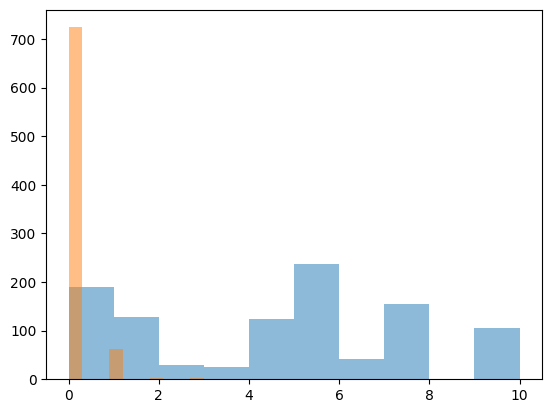

In [ ]:
# Generate data for rw=True
between_link_data_true = [num_between_links(G, sample_groups(G, 5, rw=True)) for _ in range(1)]
between_link_data_true = [item for sublist in between_link_data_true for item in sublist]

# Generate data for rw=False
between_link_data_false = [num_between_links(G, sample_groups(G, 5, rw=False)) for _ in range(1)]
between_link_data_false = [item for sublist in between_link_data_false for item in sublist]

# Plot on the i-th subplot
plt.hist(between_link_data_true, alpha=0.5, label='rw=True')
plt.hist(between_link_data_false, alpha=0.5, label='rw=False')

plt.set_title(f'Histogram for q={5}')  # Set the title of the i-th subplot
plt.legend()  # Add a legend to the i-th subplot

plt.show()

As we can see for reasonably sized q, the number of between links we actually see within a batch is skewed right. This means that even though we try aggregating different clusters together into a batch so we can capture between cluster edges, the number of times we see these relationship is low.

I try increasing the probability by using random walk sampling treating the clusters as part of their own graph rather than simply random sampling

In [ ]:
from load import load_data

data = load_data(1)

In [ ]:
connectivity_data = np.load('../data/xbar/1/xbar_connectivity.npz')

In [ ]:
set(connectivity_data['data'])

{1, 2, 3, 4, 5, 6}

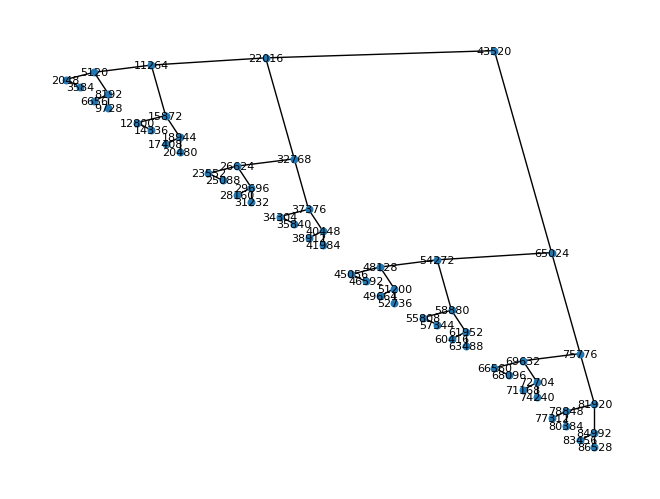

In [ ]:
def buildBST(array,start=0,finish=-1):
    if finish<0:
        finish = len(array)
    mid = (start + finish) // 2
    if mid-start==1:
        ltl=start
    else:
        ltl=buildBST(array,start,mid)
    
    if finish-mid==1:
        gtl=mid
    else:
        gtl=buildBST(array,mid,finish)
        
    return((array[mid],ltl,gtl))

def print_bst(bst, indent=0):
    value, left, right = bst
    print(' ' * indent + str(value))
    if isinstance(left, tuple):
        print_bst(left, indent + 2)
    else:
        print(' ' * (indent + 2) + str(left))
    if isinstance(right, tuple):
        print_bst(right, indent + 2)
    else:
        print(' ' * (indent + 2) + str(right))


congestion_data = np.load('../data/xbar/1/xbar_congestion.npz')
xbst=buildBST(congestion_data['xBoundaryList'])
ybst=buildBST(congestion_data['yBoundaryList'])

def draw_bst(bst, parent=None, pos={}, x=0, y=0, dx=1, dy=1):
    value, left, right = bst
    pos[value] = (x, y)
    G.add_node(value)
    if parent is not None:
        G.add_edge(parent, value)
    if isinstance(left, tuple):
        pos, x, y = draw_bst(left, value, pos, x-dx, y-dy, dx/2, dy)
    if isinstance(right, tuple):
        pos, x, y = draw_bst(right, value, pos, x+dx, y-dy, dx/2, dy)
    return pos, x, y

G = nx.DiGraph()
pos, _, _ = draw_bst(xbst)
nx.draw(G, pos, with_labels=True, arrows=False, node_size=22, font_size=8)
plt.show()

In [ ]:
with gzip.open(f'../data/xbar/1/xbar.json.gz','rb') as f:
    design = json.loads(f.read().decode('utf-8'))
    
instances = pd.DataFrame(design['instances'])

def getGRCIndex(x,y,xbst,ybst):
            while (type(xbst)==tuple):
                if x < xbst[0]:
                    xbst=xbst[1]
                else:
                    xbst=xbst[2]
                    
            while (type(ybst)==tuple):
                if y < ybst[0]:
                    ybst=ybst[1]
                else:
                    ybst=ybst[2]
                    
            return ybst, xbst

demand = np.zeros(shape = [instances.shape[0],])


for k in range(instances.shape[0]):
    xloc = instances.iloc[k]['xloc']; yloc = instances.iloc[k]['yloc']
    i,j=getGRCIndex(xloc,yloc,xbst,ybst)
    d = 0 
    for l in list(congestion_data['layerList']): 
        lyr=list(congestion_data['layerList']).index(l)
        d += congestion_data['demand'][lyr][i][j]
    demand[k] = d
                
instances['routing_demand'] = demand

In [ ]:
import matplotlib.pyplot as plt

def get_leaf_nodes(bst):
    value, left, right = bst
    if not isinstance(left, tuple) and not isinstance(right, tuple):
        return [value]
    leaves = []
    if isinstance(left, tuple):
        leaves.extend(get_leaf_nodes(left))
    if isinstance(right, tuple):
        leaves.extend(get_leaf_nodes(right))
    return leaves

# Get leaf nodes for x and y BSTs
x_leaf_nodes = get_leaf_nodes(xbst)
y_leaf_nodes = get_leaf_nodes(ybst)

# Create a new figure
import matplotlib.pyplot as plt

def get_leaf_nodes(bst):
    value, left, right = bst
    if not isinstance(left, tuple) and not isinstance(right, tuple):
        return [value]
    leaves = []
    if isinstance(left, tuple):
        leaves.extend(get_leaf_nodes(left))
    if isinstance(right, tuple):
        leaves.extend(get_leaf_nodes(right))
    return leaves

# Get leaf nodes for x and y BSTs
x_leaf_nodes = get_leaf_nodes(xbst)
y_leaf_nodes = get_leaf_nodes(ybst)

# Create a new figure
plt.figure()

import matplotlib.cm as cm

# Normalize the demand values to the range [0, 1]
normalized_demand = (instances['routing_demand'] - instances['routing_demand'].min()) / (instances['routing_demand'].max() - instances['routing_demand'].min())

# Create a new colormap
cmap = cm.get_cmap('coolwarm')

# Draw each x boundary as a vertical line
for x in x_leaf_nodes:
    plt.axvline(x=x, color='black', linewidth=1, alpha=0.5)

# Draw each y boundary as a horizontal line
for y in y_leaf_nodes:
    plt.axhline(y=y, color='black', linewidth=1, alpha=0.5)

# Plot instances with colors based on demand
plt.scatter(instances['xloc'], instances['yloc'], color=cmap(normalized_demand), s=5, edgecolor='black', linewidth=0.5)
# Display the plot
plt.show()

import matplotlib.cm as cm

# Normalize the demand values to the range [0, 1]
normalized_demand = (instances['routing_demand'] - instances['routing_demand'].min()) / (instances['routing_demand'].max() - instances['routing_demand'].min())

# Create a new colormap
cmap = cm.get_cmap('hot')

# Draw each x boundary as a vertical line
for x in x_leaf_nodes:
    plt.axvline(x=x, color='black', linewidth=1, alpha=0.5)

# Draw each y boundary as a horizontal line
for y in y_leaf_nodes:
    plt.axhline(y=y, color='black', linewidth=1, alpha=0.5)

# Plot instances with colors based on demand
plt.scatter(instances['xloc'], instances['RuntimeError: Could not locate METIS dll. Please set the METIS_DLL environment variable to its full path.yloc'], color=cmap(normalized_demand), s=5)
# Display the plot
plt.show()

In [ ]:
import metis

RuntimeError: Could not locate METIS dll. Please set the METIS_DLL environment variable to its full path.

: 

C:\Users\spenc\AppData\Local\Temp\ipykernel_9404\1212054739.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')


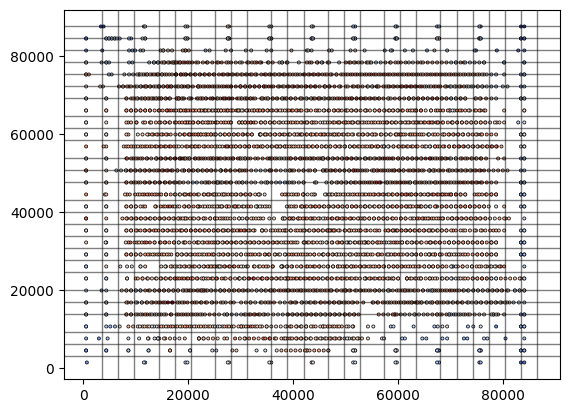

C:\Users\spenc\AppData\Local\Temp\ipykernel_9404\1212054739.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hot')


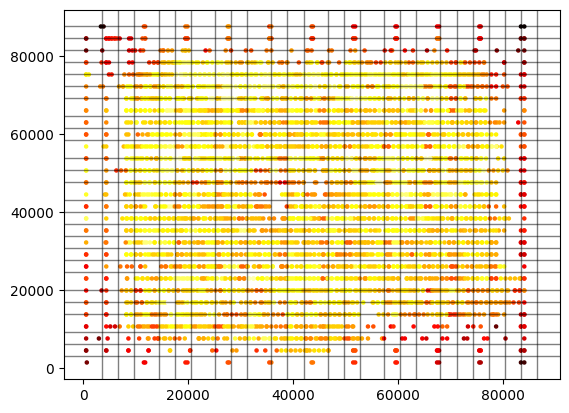

In [ ]:
import matplotlib.pyplot as plt

def get_leaf_nodes(bst):
    value, left, right = bst
    if not isinstance(left, tuple) and not isinstance(right, tuple):
        return [value]
    leaves = []
    if isinstance(left, tuple):
        leaves.extend(get_leaf_nodes(left))
    if isinstance(right, tuple):
        leaves.extend(get_leaf_nodes(right))
    return leaves

# Get leaf nodes for x and y BSTs
x_leaf_nodes = get_leaf_nodes(xbst)
y_leaf_nodes = get_leaf_nodes(ybst)

# Create a new figure
import matplotlib.pyplot as plt

def get_leaf_nodes(bst):
    value, left, right = bst
    if not isinstance(left, tuple) and not isinstance(right, tuple):
        return [value]
    leaves = []
    if isinstance(left, tuple):
        leaves.extend(get_leaf_nodes(left))
    if isinstance(right, tuple):
        leaves.extend(get_leaf_nodes(right))
    return leaves

# Get leaf nodes for x and y BSTs
x_leaf_nodes = get_leaf_nodes(xbst)
y_leaf_nodes = get_leaf_nodes(ybst)

# Create a new figure
plt.figure()

import matplotlib.cm as cm

# Normalize the demand values to the range [0, 1]
normalized_demand = (instances['routing_demand'] - instances['routing_demand'].min()) / (instances['routing_demand'].max() - instances['routing_demand'].min())

# Create a new colormap
cmap = cm.get_cmap('coolwarm')

# Draw each x boundary as a vertical line
for x in x_leaf_nodes:
    plt.axvline(x=x, color='black', linewidth=1, alpha=0.5)

# Draw each y boundary as a horizontal line
for y in y_leaf_nodes:
    plt.axhline(y=y, color='black', linewidth=1, alpha=0.5)

# Plot instances with colors based on demand
plt.scatter(instances['xloc'], instances['yloc'], color=cmap(normalized_demand), s=5, edgecolor='black', linewidth=0.5)
# Display the plot
plt.show()

import matplotlib.cm as cm

# Normalize the demand values to the range [0, 1]
normalized_demand = (instances['routing_demand'] - instances['routing_demand'].min()) / (instances['routing_demand'].max() - instances['routing_demand'].min())

# Create a new colormap
cmap = cm.get_cmap('hot')

# Draw each x boundary as a vertical line
for x in x_leaf_nodes:
    plt.axvline(x=x, color='black', linewidth=1, alpha=0.5)

# Draw each y boundary as a horizontal line
for y in y_leaf_nodes:
    plt.axhline(y=y, color='black', linewidth=1, alpha=0.5)

# Plot instances with colors based on demand
plt.scatter(instances['xloc'], instances['yloc'], color=cmap(normalized_demand), s=5)
# Display the plot
plt.show()